* In this activity, we will investigate the impact of "amount of data" and missing/noisy data
* For a dataset of your choice, iteratively decrease the total number of data (rows) and and evaluate the accuracy/MAE on the validation set - please do not change the validation set (keep the same number of rows in each run); only decrease the number of rows in the training set.
    * Expected output: A plot showing how the # of rows (x-axis) impacts the accuracy/MAE on validation data (y-axis) - with at least 8/10 points on the plot (for example: 1%, 2%, 5%, 10%, 20%, 40%, 60%, and 80%)
* Randomly set random rows/columns (around 10% of your total rows) to non-standard values such as -9999 or 9999 and repeat your training/evaluation.
    * Expected output: Your discussion of how noisy data impacts the accuracy/MAE on the validation set

In [1]:
# Import modules
from google.colab import files
import matplotlib.pyplot as plt
from functools import *
import re  # For removing letter in string 
import operator  # For sorting dictionary
import random
import math
import seaborn as sns
import pandas as pd
import numpy as np
np.set_printoptions(formatter = {'float': '{: 0.1f}'.format})

import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


# **Import and Setup**

In [2]:
uploaded = files.upload()
file_name = "heart.csv"

Saving heart.csv to heart.csv


In [3]:
dataset = pd.read_csv(file_name, delimiter=',')
print(dataset.shape)
dataset.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### **Add noise to Dataset**

In [4]:
dataset_noise = dataset.copy()
for i in range(100):
    rand_row = random.randint(0, len(dataset_noise) - 1)  # Choose a random row
    rand_col = random.randint(0, len(dataset_noise.iloc[0, :]) - 2)  # Choose a random column (except the last/output column)
    dataset_noise.iloc[rand_row, rand_col] = 9999
    print("[%s,%s] - BEFORE: %s | AFTER: %s" % (rand_row, rand_col, dataset.iloc[rand_row, rand_col], dataset_noise.iloc[rand_row, rand_col]))

[49,11] - BEFORE: 0 | AFTER: 9999
[266,0] - BEFORE: 55 | AFTER: 9999
[66,8] - BEFORE: 1 | AFTER: 9999
[270,3] - BEFORE: 120 | AFTER: 9999
[193,0] - BEFORE: 60 | AFTER: 9999
[128,4] - BEFORE: 196 | AFTER: 9999
[81,2] - BEFORE: 1 | AFTER: 9999
[50,4] - BEFORE: 256 | AFTER: 9999
[182,7] - BEFORE: 169 | AFTER: 9999
[144,10] - BEFORE: 1 | AFTER: 9999
[30,5] - BEFORE: 0 | AFTER: 9999
[265,2] - BEFORE: 0 | AFTER: 9999
[290,8] - BEFORE: 0 | AFTER: 9999
[199,1] - BEFORE: 1 | AFTER: 9999
[205,7] - BEFORE: 161 | AFTER: 9999
[71,4] - BEFORE: 227 | AFTER: 9999
[268,4] - BEFORE: 286 | AFTER: 9999
[60,4] - BEFORE: 265 | AFTER: 9999
[7,12] - BEFORE: 3 | AFTER: 9999
[177,10] - BEFORE: 2 | AFTER: 9999
[298,3] - BEFORE: 140 | AFTER: 9999
[222,10] - BEFORE: 1 | AFTER: 9999
[138,2] - BEFORE: 0 | AFTER: 9999
[239,0] - BEFORE: 35 | AFTER: 9999
[218,0] - BEFORE: 65 | AFTER: 9999
[11,7] - BEFORE: 139 | AFTER: 9999
[99,9] - BEFORE: 0.0 | AFTER: 9999.0
[100,3] - BEFORE: 148 | AFTER: 9999
[56,1] - BEFORE: 1 | AFT

# **NN Model (Regression)**

#### Normal Dataset


In [0]:
# Shuffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

X = dataset.drop('age', axis='columns').values
Y = dataset['age'].values

In [6]:
# Index for 20%
index_percentA = int(0.2 * len(dataset.iloc[:, 0]))
index_percentB = int(0.8 * len(dataset.iloc[:, 0]))

## Split into validation
XVALID = X[:index_percentA, :]
YVALID = Y[:index_percentA]

normal_dataset_labels = []
normal_dataset_mae = []
for i in range(1, 11):
    ## Split into training and clone valid set
    xtrain = X[index_percentA:, :]
    ytrain = Y[index_percentA:]
    xvalid = XVALID.copy()
    yvalid = YVALID.copy()

    ## The number of rows for this percentage
    index_percentC = int(math.ceil( ((i * 10) * index_percentB) / 100 ))
    
    ## Get the specific rows from the training set
    xtrain = xtrain[:index_percentC]
    ytrain = ytrain[:index_percentC]
    print("%s%% | XTRAIN: %s | YTRAIN: %s " % (i * 10, xtrain.shape, ytrain.shape))

    ## Mean normalization
    min = xtrain.min(axis = 0) 
    max = xtrain.max(axis = 0) 
    mean = xtrain.mean(axis = 0)
    xtrain = (xtrain - mean) / (max - min)
    xvalid = (xvalid - mean) / (max - min)

    ## Rescaling
    ymax = ytrain.max()
    ytrain = ytrain / ymax
    yvalid = yvalid / ymax

    ## Setting up callback
    callback_a = ModelCheckpoint(filepath = "clean_regression.hdf5", monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    ## Model creation, complie, and fit
    model = Sequential()
    model.add(Dense(13, input_dim=len(xtrain[0, :]), activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
    history = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=1024, batch_size=30, callbacks = [callback_a, callback_b], verbose=0)

    ## Get Prediction
    model.load_weights("clean_regression.hdf5")
    prediction = model.predict(xvalid)
    mae_score = mean_absolute_error(yvalid, prediction)

    ## Save Result
    print("MAE: %.2f" % mae_score)
    normal_dataset_labels.append("%s%%" % (i * 10))
    normal_dataset_mae.append(mae_score)

10% | XTRAIN: (25, 13) | YTRAIN: (25,) 
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
MAE: 0.19
20% | XTRAIN: (49, 13) | YTRAIN: (49,) 
MAE: 0.13
30% | XTRAIN: (73, 13) | YTRAIN: (73,) 
MAE: 0.13
40% | XTRAIN: (97, 13) | YTRAIN: (97,) 
MAE: 0.13
50% | XTRAIN: (121, 13) | YTRAIN: (121,) 
MAE: 0.10
60% | XTRAIN: (146, 13) | YTRAIN: (146,) 
MAE: 0.08
70% | XTRAIN: (170, 13) | YTRAIN: (170,) 
MAE: 0.10
80% | XTRAIN: (194, 13) | YTRAIN: (194,) 
MAE: 0.09
90% | XTRAIN: (218, 13) | YTRAIN: (218,) 
MAE: 0.09
100% | XTRAIN: (242, 13) | YTRAIN: (242,) 
MAE: 0.09


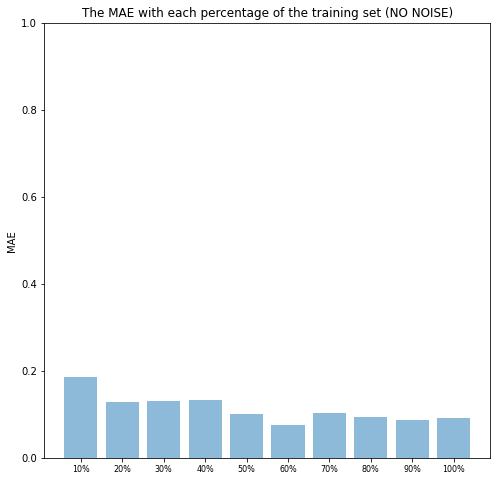

In [7]:
y_pos = np.arange(len(normal_dataset_labels))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, normal_dataset_mae, align='center', alpha=0.5)
plt.xticks(y_pos, normal_dataset_labels, fontsize=8)
plt.ylim(0, 1)
plt.ylabel('MAE')
plt.title('The MAE with each percentage of the training set (NO NOISE)')

plt.show()

#### Noisy Dataset

In [0]:
# Shuffle the dataset_noise
dataset_noise = dataset_noise.sample(frac=1).reset_index(drop=True)

X = dataset_noise.drop('age', axis='columns').values
Y = dataset_noise['age'].values

In [9]:
# Index for 20%
index_percentA = int(0.2 * len(dataset_noise.iloc[:, 0]))
index_percentB = int(0.8 * len(dataset_noise.iloc[:, 0]))

## Split into validation
XVALID = X[:index_percentA, :]
YVALID = Y[:index_percentA]

noise_normal_dataset_labels = []
noise_normal_dataset_mae = []
for i in range(1, 11):
    ## Split into training and clone valid set
    xtrain = X[index_percentA:, :]
    ytrain = Y[index_percentA:]
    xvalid = XVALID.copy()
    yvalid = YVALID.copy()

    ## The number of rows for this percentage
    index_percentC = int(math.ceil( ((i * 10) * index_percentB) / 100 ))
    
    ## Get the specific rows from the training set
    xtrain = xtrain[:index_percentC]
    ytrain = ytrain[:index_percentC]
    print("%s%% | XTRAIN: %s | YTRAIN: %s " % (i * 10, xtrain.shape, ytrain.shape))

    ## Mean normalization
    min = xtrain.min(axis = 0) 
    max = xtrain.max(axis = 0) 
    mean = xtrain.mean(axis = 0)
    xtrain = (xtrain - mean) / (max - min)
    xvalid = (xvalid - mean) / (max - min)

    ## Rescaling
    ymax = ytrain.max()
    ytrain = ytrain / ymax
    yvalid = yvalid / ymax

    ## Setting up callback
    callback_a = ModelCheckpoint(filepath = "noise_regression.hdf5", monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    ## Model creation, complie, and fit
    model = Sequential()
    model.add(Dense(13, input_dim=len(xtrain[0, :]), activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
    history = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=1024, batch_size=30, callbacks = [callback_a, callback_b], verbose=0)

    ## Get Prediction
    model.load_weights("noise_regression.hdf5")
    prediction = model.predict(xvalid)
    mae_score = mean_absolute_error(yvalid, prediction)

    ## Save Result
    print("MAE: %.2f" % mae_score)
    noise_normal_dataset_labels.append("%s%%" % (i * 10))
    noise_normal_dataset_mae.append(mae_score)

10% | XTRAIN: (25, 13) | YTRAIN: (25,) 
MAE: 12.88
20% | XTRAIN: (49, 13) | YTRAIN: (49,) 
MAE: 4.37
30% | XTRAIN: (73, 13) | YTRAIN: (73,) 
MAE: 0.38
40% | XTRAIN: (97, 13) | YTRAIN: (97,) 
MAE: 0.08
50% | XTRAIN: (121, 13) | YTRAIN: (121,) 
MAE: 0.06
60% | XTRAIN: (146, 13) | YTRAIN: (146,) 
MAE: 0.05
70% | XTRAIN: (170, 13) | YTRAIN: (170,) 
MAE: 0.05
80% | XTRAIN: (194, 13) | YTRAIN: (194,) 
MAE: 0.06
90% | XTRAIN: (218, 13) | YTRAIN: (218,) 
MAE: 0.05
100% | XTRAIN: (242, 13) | YTRAIN: (242,) 
MAE: 0.06


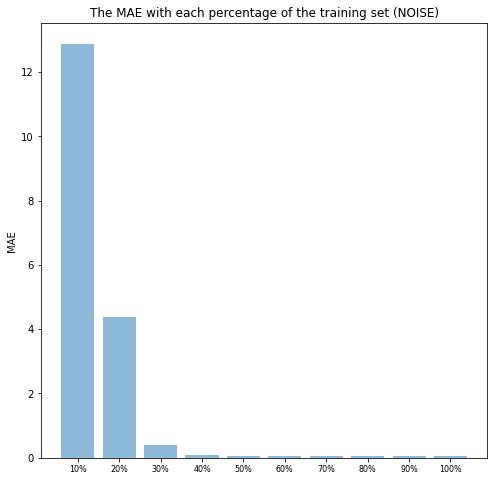

In [10]:
y_pos = np.arange(len(noise_normal_dataset_labels))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, noise_normal_dataset_mae, align='center', alpha=0.5)
plt.xticks(y_pos, noise_normal_dataset_labels, fontsize=8)
plt.ylabel('MAE')
plt.title('The MAE with each percentage of the training set (NOISE)')

plt.show()

#### **Side by Side**

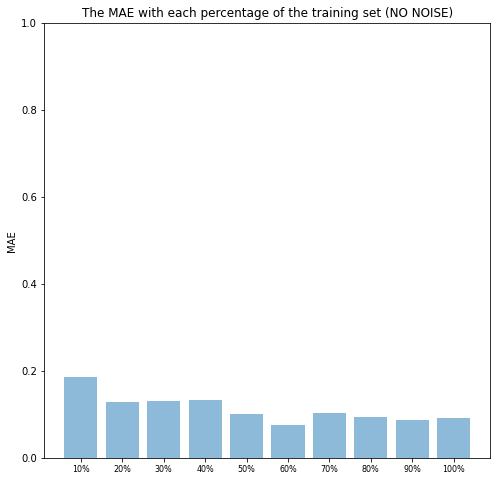

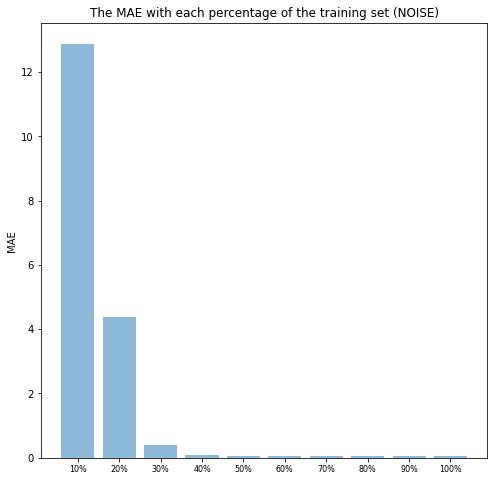

In [11]:
def no_noise():
    y_pos = np.arange(len(normal_dataset_labels))

    plt.figure(figsize=(8, 8))
    plt.bar(y_pos, normal_dataset_mae, align='center', alpha=0.5)
    plt.xticks(y_pos, normal_dataset_labels, fontsize=8)
    plt.ylim(0, 1)
    plt.ylabel('MAE')
    plt.title('The MAE with each percentage of the training set (NO NOISE)')

    plt.show()

def with_noise():
    y_pos = np.arange(len(noise_normal_dataset_labels))

    plt.figure(figsize=(8, 8))
    plt.bar(y_pos, noise_normal_dataset_mae, align='center', alpha=0.5)
    plt.xticks(y_pos, noise_normal_dataset_labels, fontsize=8)
    plt.ylabel('MAE')
    plt.title('The MAE with each percentage of the training set (NOISE)')

    plt.show()

no_noise()
with_noise()